In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from scipy.optimize import minimize
import seaborn as sns
import scipy.stats as ss


# Set seed
np.random.seed(42)

## Data Handling

In [52]:
df = pd.read_csv('df_fuel_ckan.csv')

# Convert the DATETIME column to datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Set the DATETIME column as the index
df.set_index('DATETIME', inplace=True)
# Resample to daily data (summing half-hourly observations)
df_daily = df.resample('D').sum()

# Create a time index and extract day-of-year for seasonal indicators
df_daily['t'] = np.arange(len(df_daily))
df_daily['dayofyear'] = df_daily.index.dayofyear

# Define seasonal indicators based on day-of-year:
df_daily['summer'] = ((df_daily['dayofyear'] >= 150) & (df_daily['dayofyear'] <= 240)).astype(int)
df_daily['autumn'] = ((df_daily['dayofyear'] > 240) & (df_daily['dayofyear'] <= 330)).astype(int)
df_daily['winter'] = ((df_daily['dayofyear'] > 330) | (df_daily['dayofyear'] <= 60)).astype(int)
# Spring is the baseline (days not in summer, autumn, or winter)
df_daily['spring'] = 1 - (df_daily['summer'] + df_daily['autumn'] + df_daily['winter'])


Since the GPD based peaks-over-threshold method assumes that the data are approximately stationary in terms of both mean and variability. If the renewable data exhibits a strong upward trend and increasing variability over time, then directly applying the GPD model will capture those trends rather than the intrinsic tail behavior. 

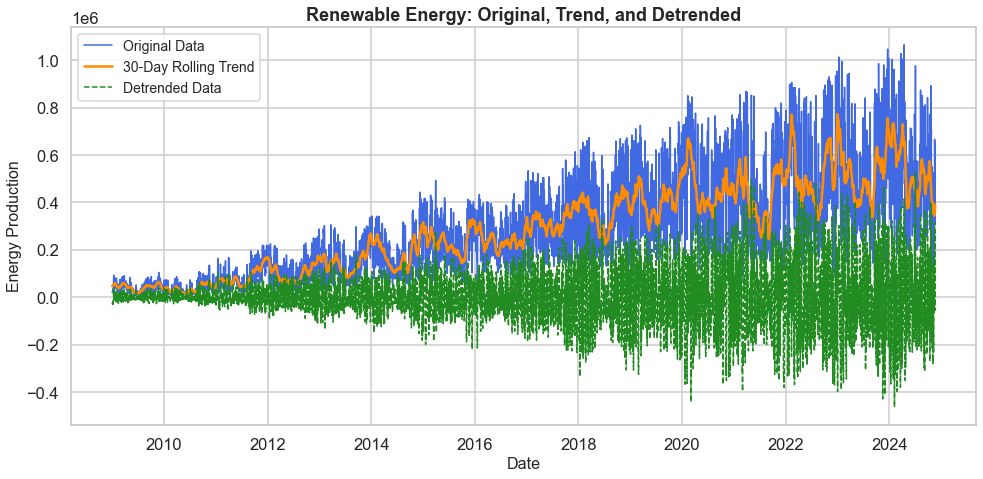

In [ ]:
# Detrend the data by subtracting the mean of each day-of-year
# Define a window (30 days) for the rolling average
window = 30

# Calculate the rolling average
df_daily['trend'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).mean()

# Detrend by subtracting the rolling average from the original data
df_daily['detrended'] = df_daily['RENEWABLE'] - df_daily['trend']


sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(df_daily.index, df_daily['RENEWABLE'], 
         label='Original Data', linewidth=1.5, color='royalblue')

# Plot the rolling average 
plt.plot(df_daily.index, df_daily['trend'], 
         label='30-Day Rolling Trend', linewidth=2.5, color='darkorange')

# Plot the detrended data
plt.plot(df_daily.index, df_daily['detrended'], 
         label='Detrended Data', linestyle='--', linewidth=1.5, color='forestgreen')


plt.title('Renewable Energy: Original, Trend, and Detrended', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Energy Production', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.tight_layout()

plt.show()


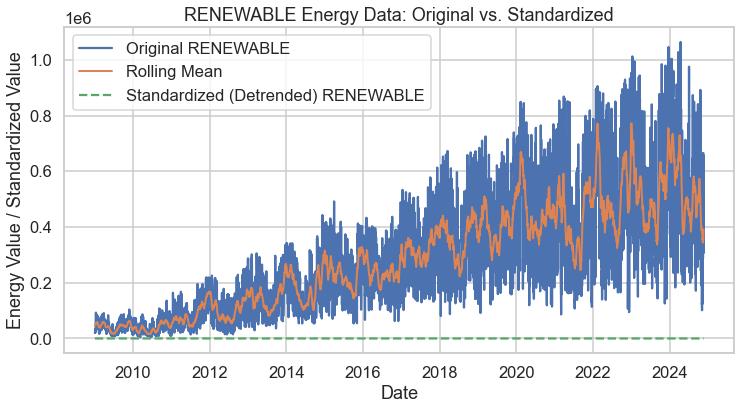

In [54]:
df_daily['rolling_mean'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).mean()
df_daily['rolling_std'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).std()

# Standardize the data
df_daily['std_detrended'] = (df_daily['RENEWABLE'] - df_daily['rolling_mean']) / df_daily['rolling_std']

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['RENEWABLE'], label='Original RENEWABLE')
plt.plot(df_daily.index, df_daily['rolling_mean'], label='Rolling Mean', linewidth=2)
plt.plot(df_daily.index, df_daily['std_detrended'], label='Standardized (Detrended) RENEWABLE', linestyle='--')
plt.legend()
plt.title('RENEWABLE Energy Data: Original vs. Standardized')
plt.xlabel('Date')
plt.ylabel('Energy Value / Standardized Value')
plt.show()


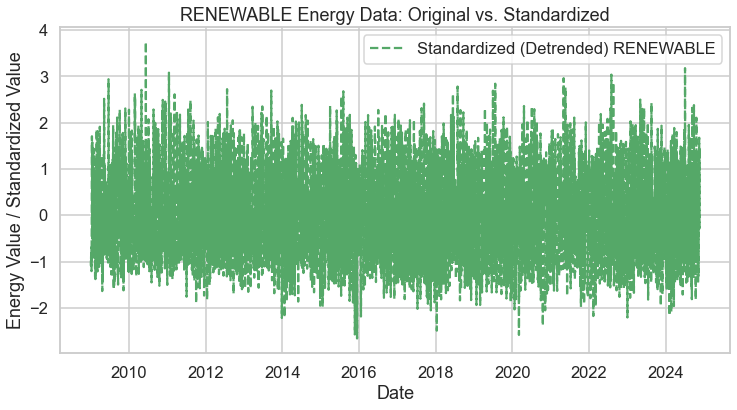

In [55]:
# Plot the standardized detrended data
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['std_detrended'], label='Standardized (Detrended) RENEWABLE', color = 'g',linestyle='--')
plt.legend()
plt.title('RENEWABLE Energy Data: Original vs. Standardized')
plt.xlabel('Date')
plt.ylabel('Energy Value / Standardized Value')
plt.show()

## Introduce all help functions

This includes all the functions that are used to fit the GPD model to the data.

In [ ]:
EPSILON = 1e-10

def sigma_t(params, t, summer, autumn, winter):
    sigma_0, beta_1, beta_2, beta_3, beta_4 = params
    return np.maximum(sigma_0 + beta_1 * t + beta_2 * summer + beta_3 * autumn + beta_4 * winter, 1e-10)

def simulate_data(params, t, summer, autumn, winter):
    sigma_params = params[:-1]
    xi = params[-1]
    sig = sigma_t(sigma_params, t, summer, autumn, winter)
    # Generate uniform random variables
    U = np.random.uniform(0, 1, size=len(t))
    # Use the inverse CDF of the generalized Pareto distribution.
    if np.abs(xi) > 1e-8:
        X_sim = sig * (((1 - U) ** (-xi)) - 1) / xi
    else:
        X_sim = sig * (-np.log(1 - U))
    return X_sim


def mean_excess(data, k):
    # Calculate the mean excess above threshold k
    exceedances = data[data > k] - k
    return np.mean(exceedances) if len(exceedances) > 0 else np.nan

def log_likelihood(params, X, t, summer, autumn, winter):
    # Unpack parameters: first five for sigma_t and the sixth for xi
    sigma_params = params[:-1]  # [sigma_0, beta_1, beta_2, beta_3, beta_4]
    xi = params[-1]
    
    # Compute the dynamic sigma_t values
    sigma_t_values = sigma_t(sigma_params, t, summer, autumn, winter)
    
    # Check the constraint: the argument of the log must be positive
    if np.any(1 + xi * (X / sigma_t_values) <= 0):
        return np.inf  # Penalize invalid parameter regions
    
    # Compute log-likelihood components
    term1 = -np.log(sigma_t_values)
    term2 = -(1 + 1 / xi) * np.log(1 + xi * (X / sigma_t_values))
    
    # Return the negative log-likelihood
    return -np.sum(term1 + term2)

#  Tail‐only log‐likelihood
def loglik_tail(params, Y, t, summer, autumn, winter):
    sigma_params = params[:-1]
    xi = params[-1]
    sigma_values = sigma_t(sigma_params, t, summer, autumn, winter)
    if np.any(1 + xi * (Y / sigma_values) <= 0):
        return np.inf
    term1 = -np.log(sigma_values)
    term2 = -(1 + 1 / xi) * np.log(1 + xi * (Y / sigma_values))
    return -np.sum(term1 + term2)



In [ ]:
# Use the RENEWABLE column as the variable
X = df_daily['std_detrended'].values
t = df_daily['t'].values
summer = df_daily['summer'].values
autumn = df_daily['autumn'].values
winter = df_daily['winter'].values
spring = df_daily['spring'].values

## Model Fitting

In [ ]:
# Pick a single threshold u
u  = np.quantile(X, 0.975)
param_names = ['σ0','β1','β2','β3','β4','xi']

# Extract the exceedances
mask_ex   = (X > u)
Y         = X[mask_ex] - u
t_ex      = t[mask_ex]
spring_ex= spring[mask_ex]
summer_ex = summer[mask_ex]
autumn_ex = autumn[mask_ex]
winter_ex = winter[mask_ex]

me_sp = mean_excess(X[spring==1], u)  # mean excess for spring
me_su = mean_excess(X[summer==1], u)  # mean excess for summer
me_au = mean_excess(X[autumn==1], u)  # mean excess for autumn
me_wi = mean_excess(X[winter==1], u)  # mean excess for winter

# Initial parameter estimates
sigma0_init = me_sp
beta1_init  = 0.0
beta2_init  = me_su - me_sp
beta3_init  = me_au - me_sp
beta4_init  = me_wi - me_sp
xi_init     = -0.1
'''sigma0_init = mean_excess(X, u)
beta1_init  = 0.0
beta2_init  = beta3_init = beta4_init = 0.0
xi_init     = 0.1'''

init_params = [sigma0_init,
               beta1_init,
               beta2_init,
               beta3_init,
               beta4_init,
               xi_init]

# Bounds on parameters
bounds = [
    (0.0, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (-1, 1)
]

# Run the fit
res_tail = minimize(
    loglik_tail,
    x0=init_params,
    args=(Y, t_ex, summer_ex, autumn_ex, winter_ex),
    method="L-BFGS-B",
    bounds=bounds
)

sig0_hat, β1_hat, β2_hat, β3_hat, β4_hat, xi_hat = res_tail.x

print("Tail‐only MLE results:")
print(f"  sig0 = {sig0_hat:.4f}")
print(f"  β1 = {β1_hat:.4f}, β2 = {β2_hat:.4f}, β3 = {β3_hat:.4f}, β4 = {β4_hat:.4f}")
print(f"  xi  = {xi_hat:.4f}")


Tail‐only MLE results:
  sig0 = 0.3200
  β1 = -0.0000, β2 = 0.1596, β3 = -0.0433, β4 = 0.0474
  xi  = -0.0753


/Applications/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
sig_params_hat = res_tail.x[:-1]
xi_hat = res_tail.x[-1]
Xb_list = []

n = len(X)
n_boot = 100
boot_est = np.zeros((n_boot, 6))
u_boot = np.zeros(n_boot)  # to store threshold in each replicate


for i in range(n_boot):
    # Following the steps of semi‐parametric bootstrap from the thesis:
    # Step 1: Resample the entire series
    idx_star = np.random.choice(n, size=n, replace=True)
    X_star = X[idx_star]
    t_star = t[idx_star]
    summer_s = summer[idx_star]
    autumn_s = autumn[idx_star]
    winter_s = winter[idx_star]
    spring_s = spring[idx_star]

    # Step 2: Recompute threshold on X_star
    u_star = np.quantile(X_star, 0.975)
    u_boot[i] = u_star

    # Step 3: Tail-only GPD fit on X_star exceedances
    mask_ex = X_star > u_star
    Y_star = X_star[mask_ex] - u_star
    res_star = minimize(
        loglik_tail,
        x0=init_params,
        args=(Y_star,
              t_star[mask_ex],
              summer_s[mask_ex],
              autumn_s[mask_ex],
              winter_s[mask_ex]),
        method="L-BFGS-B",
        bounds=bounds
    )
    theta_star = res_star.x
    sig_params_star, xi_star = theta_star[:-1], theta_star[-1]

    # Step 4: Simulation of exceedances

    sig_ex = sigma_t(sig_params_star,
                     t_star[mask_ex],
                     summer_s[mask_ex],
                     autumn_s[mask_ex],
                     winter_s[mask_ex])
    exc = genpareto.rvs(c=xi_star, loc=0, scale=sig_ex, size=sig_ex.shape)
    sim_ex = exc + u_star

    # Step 5: Reassemble the simulated data
    Xb = X_star.copy()
    Xb[mask_ex]  = sim_ex
    Xb_list.append(Xb)

    # Step 6: Re‐fit tail only to Xb exceedances
    Yb = Xb[mask_ex] - u_star
    resb = minimize(
        loglik_tail,
        x0=theta_star,
        args=(Yb,
              t_star[mask_ex],
              summer_s[mask_ex],
              autumn_s[mask_ex],
              winter_s[mask_ex]),
        method="L-BFGS-B",
        bounds=bounds
    )
    boot_est[i] = resb.x

# Empirical 95% CIs
conf_ints = np.percentile(boot_est, [2.5, 97.5], axis=0)

print("\n95% CI from full‐sample semi‐parametric bootstrap:")
for name, ci in zip(param_names, conf_ints.T):
    print(f"{name}: [{ci[0]:.5f}, {ci[1]:.5f}]")




95% CI from full‐sample semi‐parametric bootstrap:
σ0: [0.21360, 0.50307]
β1: [-0.00005, 0.00003]
β2: [0.00000, 0.37343]
β3: [-0.16389, 0.11212]
β4: [-0.10118, 0.25297]
xi: [-0.40502, 0.10192]


## Return Levels

In [ ]:
Femp_u  = 0.975     # by construction


# Return periods T and get x_q
return_periods = [1, 5, 10, 20, 50]

# Define a small helper for the GPD tail‐quantile:
def Q_tail(p, sigma_tt, xi):

    if abs(xi) > 1e-12:
        return (sigma_tt / xi) * ( (1.0 - p)**(-xi) - 1.0 )
    else:
        return -sigma_tt * np.log(1.0 - p)


seasonal_sigmas = {
    "Spring": sig0_hat + β1_hat,
    "Summer": sig0_hat + β2_hat,
    "Autumn": sig0_hat + β3_hat,
    "Winter": sig0_hat + β4_hat
}

# Compute x_q for each (T, season)
results = { season: [] for season in seasonal_sigmas.keys() }

for T in return_periods:
    q = 1.0 - 1.0 / (T * 365.0)
    p = (q - Femp_u) / (1.0 - Femp_u) 
    
    for season, sigma_tt in seasonal_sigmas.items():
        qtail = Q_tail(p, sigma_tt, xi_hat)
        x_q = u + qtail
        results[season].append(x_q)

# Print out a small table
print("     Return period    Spring    Summer    Autumn    Winter")
print("     ---------------------------------------------------")
for idx, T in enumerate(return_periods):
    sp = results["Spring"][idx]
    su = results["Summer"][idx]
    au = results["Autumn"][idx]
    wi = results["Winter"][idx]
    print(f"      {T:>2d} years     {sp:>7.3f}   {su:>7.3f}   {au:>7.3f}   {wi:>7.3f}")


     Return period    Spring    Summer    Autumn    Winter
     ---------------------------------------------------
       1 years       2.564     2.889     2.476     2.660
       5 years       2.975     3.504     2.831     3.132
      10 years       3.137     3.747     2.971     3.318
      20 years       3.290     3.978     3.104     3.495
      50 years       3.482     4.265     3.269     3.714


## With Confidence Intervals

In [ ]:
seasons = ["Spring", "Summer", "Autumn", "Winter"]
n_seasons = len(seasons)
n_T = len(return_periods)

xq_boot = np.zeros((n_boot, n_seasons, n_T))

# Loop over bootstrap replicates
for b in range(n_boot):
    # retrieve u^(b) and tail‐parameters for replicate b:
    u_b = u_boot[b]
    sigma0_b, beta1_b, beta2_b, beta3_b, beta4_b, xi_b = boot_est[b]


    seasonal_sigma_b = {
        "Spring": sigma0_b + beta1_b,
        "Summer": sigma0_b + beta2_b,
        "Autumn": sigma0_b + beta3_b,
        "Winter": sigma0_b + beta4_b 
    }

    # Loop over each return period T:
    for t_idx, T in enumerate(return_periods):
        q = 1.0 - 1.0 / (T * 365.0)
        p_b = (q - Femp_u) / (1.0 - Femp_u)

        for s_idx, season in enumerate(seasons):
            sigma_t_b = seasonal_sigma_b[season]
            #  compute tail quantile Q_tail^(b)(p_b):
            qtail_b = Q_tail(p_b, sigma_t_b, xi_b)
            #  full return level x_q^(b) = u^(b) + Q_tail^(b)
            xq_boot[b, s_idx, t_idx] = u_b + qtail_b



# Create arrays for CI bounds
ci_lower = np.zeros((n_seasons, n_T))
ci_upper = np.zeros((n_seasons, n_T))

for s_idx in range(n_seasons):
    for t_idx in range(n_T):
        boot_values = xq_boot[:, s_idx, t_idx]
        lower, upper = np.percentile(boot_values, [2.5, 97.5])
        ci_lower[s_idx, t_idx] = lower
        ci_upper[s_idx, t_idx] = upper




# Seasonal sigmas at the MLE:
seasonal_sigmas_hat = {
    "Spring": sig0_hat + β1_hat,
    "Summer": sig0_hat + β2_hat,
    "Autumn": sig0_hat + β3_hat,
    "Winter": sig0_hat + β4_hat
}

xq_hat = np.zeros((n_seasons, n_T))
for t_idx, T in enumerate(return_periods):
    q = 1.0 - 1.0 / (T * 365.0)
    p_hat = (q - Femp_u) / (1.0 - Femp_u)
    u_hat = u
    for s_idx, season in enumerate(seasons):
        sigma_t_hat = seasonal_sigmas_hat[season]
        qtail_hat = Q_tail(p_hat, sigma_t_hat, xi_hat)
        xq_hat[s_idx, t_idx] = u_hat + qtail_hat

# Print or store the results in a neat table.
header = "Return Period     |"
for season in seasons:
    header += f"   {season:^20s}|"
print(header)
print("-" * len(header))

# Print one row per return period
for t_idx, T in enumerate(return_periods):
    row_str = f"{T:>12d} yr   |"
    for s_idx in range(n_seasons):
        h  = xq_hat[s_idx, t_idx]
        lo = ci_lower[s_idx, t_idx]
        up = ci_upper[s_idx, t_idx]
        cell = f"{h:6.2f} ({lo:5.2f},{up:5.2f})"
        row_str += f" {cell:^20s}|"
    print(row_str)

Return Period     |          Spring       |          Summer       |          Autumn       |          Winter       |
-------------------------------------------------------------------------------------------------------------------
           1 yr   |   2.56 ( 2.27, 2.94)|   2.89 ( 2.53, 3.27)|   2.48 ( 2.20, 2.83)|   2.66 ( 2.37, 3.04)|
           5 yr   |   2.97 ( 2.46, 3.79)|   3.50 ( 2.80, 4.24)|   2.83 ( 2.33, 3.56)|   3.13 ( 2.57, 3.95)|
          10 yr   |   3.14 ( 2.52, 4.21)|   3.75 ( 2.87, 4.72)|   2.97 ( 2.37, 3.86)|   3.32 ( 2.64, 4.37)|
          20 yr   |   3.29 ( 2.58, 4.64)|   3.98 ( 2.91, 5.25)|   3.10 ( 2.40, 4.21)|   3.49 ( 2.69, 4.81)|
          50 yr   |   3.48 ( 2.63, 5.27)|   4.26 ( 2.97, 5.98)|   3.27 ( 2.43, 4.78)|   3.71 ( 2.74, 5.40)|


## Return Levels with Confidence Intervals Plot

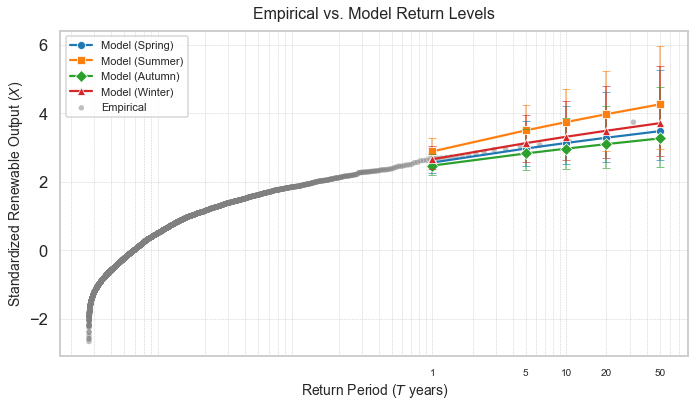

In [ ]:
n = len(X)
# Sort ascending:
sorted_X = np.sort(X)

# Compute plotting‐positions and empirical return periods (in years):
plot_positions = (np.arange(1, n + 1) - 0.5) / n   
T_days_emp    = 1.0 / (1.0 - plot_positions)  
T_years_emp   = T_days_emp / 365.0   


rp         = np.array(return_periods) 
xq_hat_arr = np.asarray(xq_hat)    
ci_lo      = np.asarray(ci_lower)
ci_hi      = np.asarray(ci_upper)




# Plot
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1.0) 

palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']


fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    x=T_years_emp,
    y=sorted_X,
    s=30,
    color='gray',
    alpha=0.5,
    edgecolor='none',
    label='Empirical',
    ax=ax
)

markers = ['o', 's', 'D', '^']
for idx, season in enumerate(seasons):
    sns.lineplot(
        x=rp,
        y=xq_hat_arr[idx, :],
        marker=markers[idx],
        linewidth=2.2,
        markersize=8,
        color=palette[idx],
        label=f"Model ({season})",
        ax=ax
    )

    lower_err = xq_hat_arr[idx, :] - ci_lo[idx, :]
    upper_err = ci_hi[idx, :] - xq_hat_arr[idx, :]
    yerr = np.vstack((lower_err, upper_err))

    ax.errorbar(
        rp,
        xq_hat_arr[idx, :],
        yerr=yerr,
        fmt='none',
        ecolor=palette[idx],
        alpha=0.6,
        capsize=4,
        linewidth=1.5
    )

ax.set_xscale('log')
ax.set_xticks(rp)
ax.set_xticklabels(rp, fontsize=10)
ax.set_xlabel('Return Period ($T$ years)', fontsize=14)
ax.set_ylabel('Standardized Renewable Output ($X$)', fontsize=14)
ax.set_title('Empirical vs. Model Return Levels', fontsize=16, pad=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper left', frameon=True, fontsize=11, title=None)

# Tighten layout and show
plt.tight_layout()
plt.show()


## Seasonal Return Levels Plot

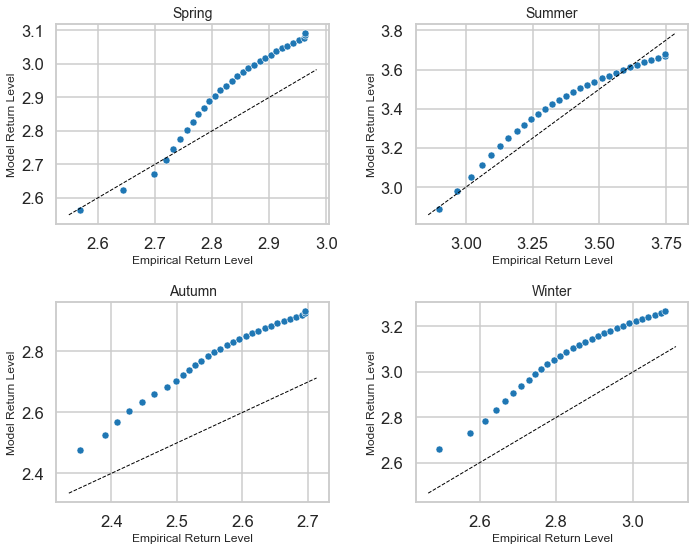

In [ ]:
mask_spring = (spring == 1)
mask_summer = (summer == 1)
mask_autumn = (autumn == 1)
mask_winter = (winter == 1)
return_periods = np.arange(1, 8.5, 0.25)
n_T = len(return_periods)
xq_hat = np.zeros((n_seasons, n_T))



for t_idx, T in enumerate(return_periods):
    q = 1.0 - 1.0/(T*365.0)
    p_hat = (q - Femp_u)/(1 - Femp_u)
    for s_idx, season in enumerate(seasons):
        sigma_t_hat = seasonal_sigmas_hat[season]
        qtail_hat    = Q_tail(p_hat, sigma_t_hat, xi_hat)
        xq_hat[s_idx, t_idx] = u_hat + qtail_hat


# Collect them in the same order as xq_hat rows
seasons = ["Spring", "Summer", "Autumn", "Winter"]
masks   = [mask_spring, mask_summer, mask_autumn, mask_winter]

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)

# We want to know the global x/y range across all seasons so we can share limits
emp_vals = []
mod_vals = []

for s_idx in range(len(seasons)):
    # Extract the sorted empirical values and corresponding T‐values for each season:
    X_season = X[masks[s_idx]]
    if X_season.size == 0:
        continue

    sorted_s = np.sort(X_season)
    n_s = len(sorted_s)
    pp_s = (np.arange(1, n_s + 1) - 0.5) / n_s
    Tdays_s = 1.0 / (1.0 - pp_s)           # return period in days
    Tyrs_s = Tdays_s / 365.0               # return period in years

    # Interpolate empirical return level at each target T
    T_target = np.array(return_periods)
    X_emp_at_T = np.interp(
        T_target,
        Tyrs_s,
        sorted_s,
        left=sorted_s[0],
        right=sorted_s[-1]
    )
    # Append to global lists
    emp_vals.append(X_emp_at_T)
    mod_vals.append(xq_hat[s_idx, :])

if len(emp_vals) > 0:
    all_emp = np.hstack(emp_vals)
    all_mod = np.hstack(mod_vals)
    global_min = min(all_emp.min(), all_mod.min())
    global_max = max(all_emp.max(), all_mod.max())

    margin = 0.02 * (global_max - global_min)
    x_lim = (global_min - margin, global_max + margin)
    y_lim = (global_min - margin, global_max + margin)
else:
    # In case all masks are empty:
    x_lim = (0, 1)
    y_lim = (0, 1)

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    season = seasons[idx]
    mask = masks[idx]
    X_season = X[mask]
    
    if X_season.size == 0:
        ax.text(0.5, 0.5, f"No data for {season}", ha="center", va="center")
        ax.set_title(season)
        continue

    # Sort and compute empirical‐return‐level at each return_periods
    sorted_s = np.sort(X_season)
    n_s = len(sorted_s)
    pp = (np.arange(1, n_s + 1) - 0.5) / n_s
    Tyrs = (1.0 / (1.0 - pp)) / 365.0
    

    X_emp = np.interp(
        return_periods, 
        Tyrs, 
        sorted_s, 
        left=sorted_s[0], 
        right=sorted_s[-1]
    )
    

    X_mod = xq_hat[idx, :]
    
    # Plot Empirical vs. Model 
    sns.scatterplot(
        x=X_emp,
        y=X_mod,
        s=50,
        color="tab:blue",
        edgecolor="white",
        ax=ax
    )
    
    # Deaw y=x line
    xmin, xmax = ax.get_xlim()
    ax.plot(
        [xmin, xmax], 
        [xmin, xmax], 
        ls="--", 
        color="black", 
        linewidth=1
    )
    
    # Titles and labels
    ax.set_title(season, fontsize=14)
    ax.set_xlabel("Empirical Return Level", fontsize=12)
    ax.set_ylabel("Model Return Level", fontsize=12)

plt.tight_layout()
plt.show()


## Weighted Average Return Levels

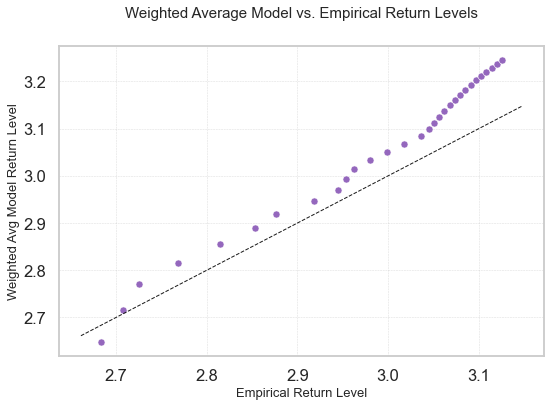

In [ ]:
w_spring = spring.mean()
w_summer = summer.mean()
w_autumn = autumn.mean()
w_winter = winter.mean()
weights = np.array([w_spring, w_summer, w_autumn, w_winter])

# Compute weighted‐average model return levels at each T
xq_weighted = (weights[:, None] * xq_hat).sum(axis=0)

# Compute full‐sample empirical return levels at those same T’s
sorted_full = np.sort(X)
n = len(sorted_full)
pp_full = (np.arange(1, n + 1) - 0.5) / n
Tdays_full = 1.0 / (1.0 - pp_full)
Tyrs_full = Tdays_full / 365.0


T_target = np.array(return_periods)
X_emp_full = np.interp(T_target, Tyrs_full, sorted_full,
                       left=sorted_full[0], right=sorted_full[-1])

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)


fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    x=X_emp_full,
    y=xq_weighted,
    s=50,
    color="tab:purple",
    edgecolor="white",
    ax=ax
)


xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], ls="--", color="k", linewidth=1)

ax.set_xlabel("Empirical Return Level", fontsize=13)
ax.set_ylabel("Weighted Avg Model Return Level", fontsize=13)
ax.set_title(
    "Weighted Average Model vs. Empirical Return Levels\n",
    fontsize=15,
    pad=12
)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# 8) Tight layout and show
plt.tight_layout()
plt.show()









## Synthetic Data

Finally the plot shows that the re-simulated data aligns well with the original data, and the GPD model is able to capture the tail behavior of the data.

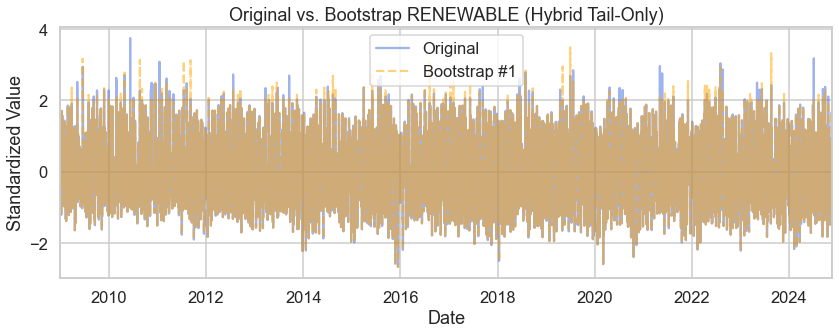

In [ ]:

# Identify exceedance positions on the original data
mask_ex   = (X > u)
idx_ex    = np.where(mask_ex)[0]

# Simulate new GPD tail values at those same indices
sigma_ex = sigma_t(sig_params_hat,
                   t[idx_ex],
                   summer[idx_ex],
                   autumn[idx_ex],
                   winter[idx_ex])


exc  = genpareto.rvs(c=xi_hat, loc=0, scale=sigma_ex, size=idx_ex.size)
sim_exceed = exc + u

# Build the bootstraps by overwriting only the exceedances
Xb_first = X.copy()
Xb_first[mask_ex] = sim_exceed

# Plot
orig_ser = pd.Series(X, index=df_daily.index, name="Original")
boot_ser = pd.Series(Xb_first, index=df_daily.index, name="Bootstrap #1")

plt.figure(figsize=(12, 5))
orig_ser.plot(alpha=0.5, label="Original", color="royalblue")
boot_ser.plot(linestyle="--", label="Bootstrap #1", color="orange", alpha=0.5)
plt.title("Original vs. Bootstrap RENEWABLE (Hybrid Tail-Only)")
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.legend()
plt.tight_layout()
plt.show()


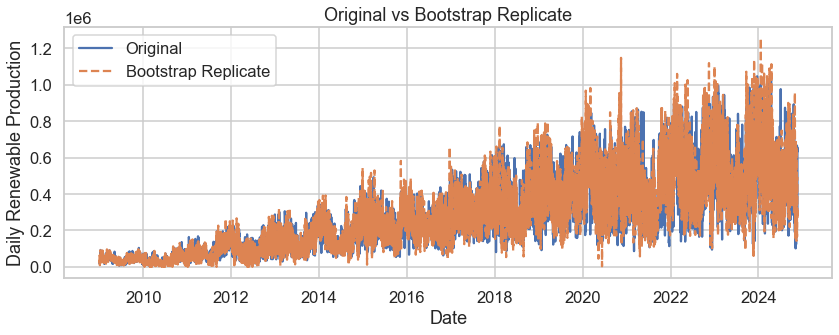

In [ ]:
Xb_std = Xb_list[0]

# Back‐transform to original scale
df_daily['boot_std']       = Xb_std
df_daily['boot_RENEWABLE'] = (
    df_daily['boot_std'] * df_daily['rolling_std']
    + df_daily['rolling_mean']
)


df_daily['boot_RENEWABLE'] = df_daily['boot_RENEWABLE'].clip(lower=0)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_daily.index, df_daily['RENEWABLE'], label='Original')
plt.plot(df_daily.index, df_daily['boot_RENEWABLE'],
         linestyle='--', label='Bootstrap Replicate')
plt.title('Original vs Bootstrap Replicate')
plt.xlabel('Date')
plt.ylabel('Daily Renewable Production')
plt.legend()
plt.tight_layout()
plt.show()

## Pairwise Plot

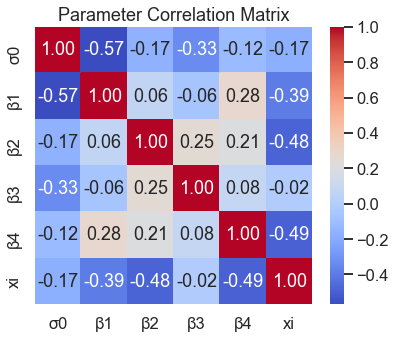

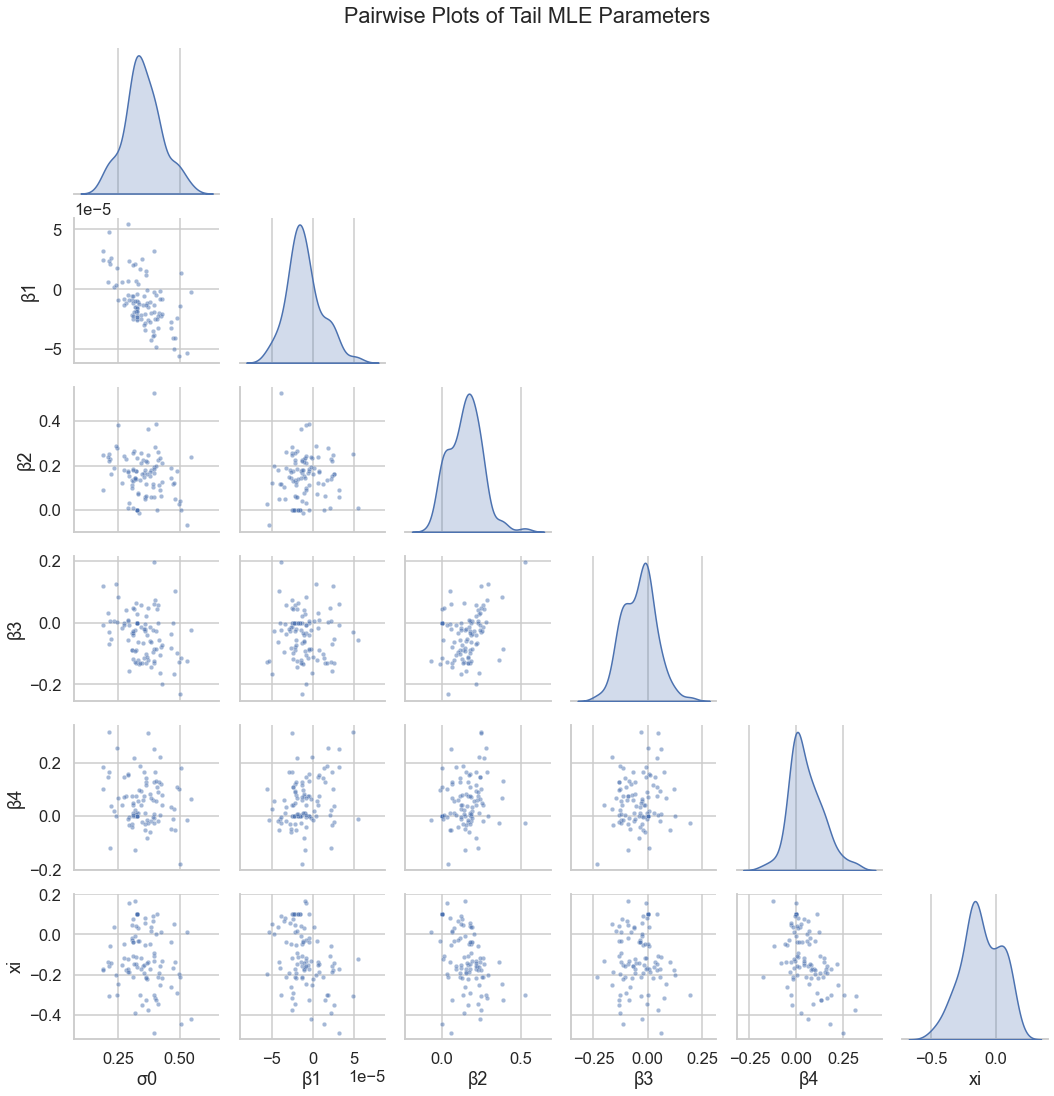

In [69]:
param_names = ['σ0','β1','β2','β3','β4','xi']
df = pd.DataFrame(
    boot_est,
    columns=param_names,
)

# Correlation matrix
corr = df.corr()
#print(corr)

# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Parameter Correlation Matrix")
plt.tight_layout()
plt.show()

# Pairwise scatter‐matrix
sns.pairplot(df, diag_kind='kde', corner=True,
             plot_kws={'alpha':0.5, 's':20})
plt.suptitle("Pairwise Plots of Tail MLE Parameters", y=1.02)
plt.show()


## To find p value

In [ ]:
N = boot_est.shape[0]
p_vals = {}

for idx, name in zip([2,3,4], ['summer','autumn','winter']):
    mle_sign = np.sign(sig_params_hat[idx])
    # proportion of replicates that have the opposite sign
    prop_opposite = np.mean(np.sign(boot_est[:,idx]) != mle_sign)

    # single sided p‐value
    p_val = prop_opposite
    # two‐sided p‐value
    #p_val = 2*min(prop_opposite, 1-prop_opposite)
    p_vals[name] = p_val

print("Seasonal empirical p-values:")
for name, p in p_vals.items():
    print(f"  {name}: {p:.3f}")


Seasonal empirical p-values:
  summer: 0.020
  autumn: 0.230
  winter: 0.330


Because the usual 0.05 significant level, can reject $H_0:$ no summer effect, at the 5 % level. This shows very strong evidence that summer exceedances are indeed larger than spring ones.

## Model Quantile against Data Quantile Comparison

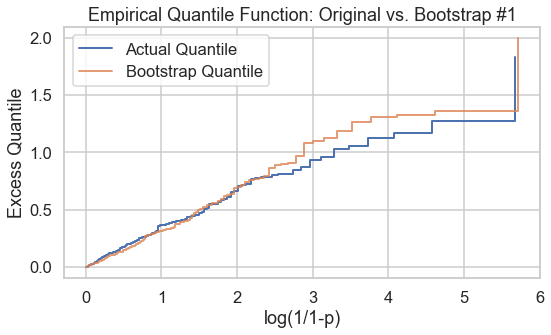

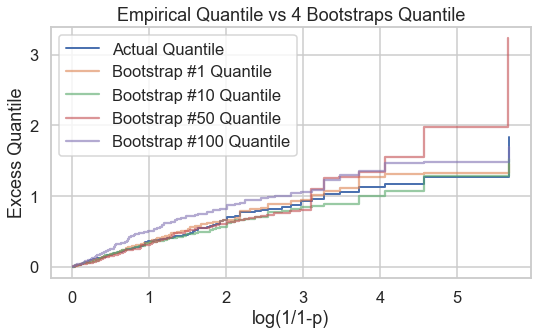

In [ ]:
def empirical_q_func(X_series, u):

    mask   = X_series > u
    Y_ex   = X_series[mask] - u
    if len(Y_ex) == 0:
        return None
    
    Y_sorted = np.sort(Y_ex)
    n        = len(Y_sorted)

    # Plotting positions
    p = (np.arange(1, n+1) - 0.5) / n

    return p, Y_sorted


# Compute the original empirical quantile staircase
u       = np.quantile(X, 0.975)
p_orig, emp_orig = empirical_q_func(X, u)

# Compute the first bootstrap empirical staircase
p_boot, emp_boot = empirical_q_func(Xb_list[4], u)


# compute log‐return‐periods
x_orig = np.log(1.0 / (1.0 - p_orig))
x_boot = np.log(1.0 / (1.0 - p_boot))
# Plot them together
plt.figure(figsize=(8,5))
plt.step(x_orig, emp_orig, where='post', label='Actual Quantile', linewidth=2)
plt.step(x_boot, emp_boot, where='post', label='Bootstrap Quantile', linewidth=2, alpha=0.8)

plt.xlabel('log(1/1-p)')
plt.ylabel('Excess Quantile')
plt.title('Empirical Quantile Function: Original vs. Bootstrap #1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute the original empirical quantile staircase
u = np.quantile(X, 0.975)
p0, emp0 = empirical_q_func(X, u)
x0 = np.log(1.0 / (1.0 - p0))  # log return period for better visualization

# Plot original staircase
plt.figure(figsize=(8,5))
plt.step(x0, emp0, where='post', label='Actual Quantile', lw=2)

# Three bootstrap staircases
colors = ['C1','C2','C3','C4']
for idx, col in zip([0, 9, 49,99], colors):
    u = u_boot[idx]  # use the bootstrap‐specific threshold
    p_b, emp_b = empirical_q_func(Xb_list[idx], u)
    x_b = np.log(1.0 / (1.0 - p_b))  # log return period
    plt.step(x_b, emp_b,
             where='post',
             color=col,
             alpha=0.6,
             label=f'Bootstrap #{idx+1} Quantile')
    
plt.xlabel('log(1/1-p)')
plt.ylabel('Excess Quantile')
plt.title('Empirical Quantile vs 4 Bootstraps Quantile')
plt.legend()
plt.tight_layout()
plt.show()


## With Confidence Intervals

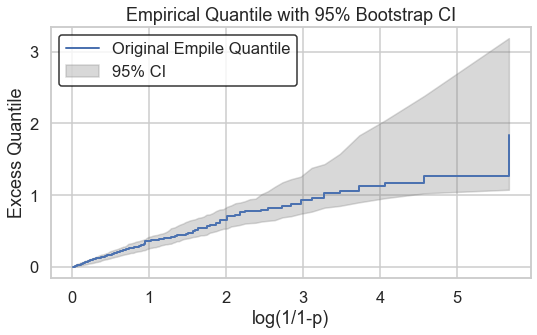

In [ ]:
n_ex = len(p_orig)
B    = len(Xb_list)
Yb_mat = np.zeros((B, n_ex))

for i, Xb in enumerate(Xb_list):
    u_i = u_boot[i]
    p_i, Yb = empirical_q_func(Xb, u_i)
    if p_i is None:
        Yb_mat[i, :] = np.nan
    else:
        Yb_mat[i, :] = np.interp(p_orig, p_i, Yb, left=Yb[0], right=Yb[-1])

lower = np.nanpercentile(Yb_mat, 2.5, axis=0)
upper = np.nanpercentile(Yb_mat, 97.5, axis=0)

# transform once
x_orig = np.log(1.0 / (1.0 - p_orig))

plt.figure(figsize=(8,5))
plt.fill_between(x_orig, lower, upper, color='gray', alpha=0.3, label='95% CI')
plt.step(x_orig, emp0, where='post', color='C0', linewidth=2, label='Original Empile Quantile')

plt.xlabel('log(1/1-p)')
plt.ylabel('Excess Quantile')
plt.title('Empirical Quantile with 95% Bootstrap CI')
plt.legend()
plt.legend(loc='upper left', frameon=True, edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.show()
